# Introduction

A telephone and internet service company wants to detect clients that could drop out its services to offer a discont as deterrence. That is of paramount importance, given that not offering a discount to someone who is planning to leave implies a cost as much as offering to someone who would not have left. The company suggest the AUC-ROC metric for the evaluation of the model.

# Objective

Detect the clients with a high probability of dropping out the service with the AUC-ROC curve as the core metric.

## Libraries to use

In [1]:
# For exploratory data analysis
import pandas as pd
import numpy as np
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# For modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# for best model selection
from sklearn.model_selection import GridSearchCV
import time

# Metric to evaluate the models
from sklearn.metrics import roc_auc_score

## Databases download

In [2]:
# Databases to use
df_cont = pd.read_csv('/datasets/final_provider/contract.csv')
df_inter = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone =  pd.read_csv('/datasets/final_provider/phone.csv')

## Exploratory Data Analysis

In this segment we will prepare an exploratory analisis. We will take into account the dataframe´s structure, integrity and its info utility.

### Initial description

The company has shared some important information with respect to the dataframes´ columns.

- `contract.csv` - dataframe about the contract
- `personal.csv` - it describes personal data about the clients.
- `interet.csv` - whether they have some internet extra servies or not. 
- `phone.csv` - whether they have one or multiple lines.

The company offers two kinds of products at its core:

- Phone communication: one or more lines.
- Internet connection: Digital Subscriber Line (DSL) or fibre optic. 

We first start with a visualisation and description for each dataframe to evaluate their completeness. 

In [3]:
# Dataframes´ dimensions, respectively
df_cont.shape, df_inter.shape, df_personal.shape, df_phone.shape

((7043, 8), (5517, 8), (7043, 5), (6361, 2))

In [4]:
# Contract dataframe
df_cont.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [5]:
# Internet DataFrame
df_inter.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [6]:
# Personal dataframe
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [7]:
# Phone dataframe
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [8]:
# Create a list of dataframes to iterate
df_list = [df_cont, df_inter, df_personal, df_phone]

In [9]:
# Df´s general info, respectively
for df in df_list:
    print(df.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517

In [10]:
# Number of null values, respectively
df_cont.isna().sum(), '', df_inter.isna().sum(),'', df_personal.isna().sum(), '', df_phone.isna().sum()
for df in df_list:
    print(df.isna().sum().sum(), '\n')

0 

0 

0 

0 



In [13]:
# Basic description of df_cont
df_cont.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [14]:
# Basic description of df_inter
df_inter.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2828-SLQPF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [15]:
# Basic description of df_personal
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
# basic description of dF_phone
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4274-OWWYO,No
freq,1,3390


In [12]:
# Duplicated elements per dataframe, respectively
for df in df_list:
    print(df.duplicated().sum(),'\n')

0 

0 

0 

0 



Initial observations:

- `customerId` is our column key.
- The data is complete for each dataframe. We have less rows for `df_inter` and `df_phone` dataframes but it could just be because not everyone has both phone-communication and internet services. However, we need to confirm that.
- We can change some datatype in some cases. We suggest to convert binary answers by integers, and to datetime where allowed. In `df_cont` there should be two float columns, but `Total charges` is object type.
- Every column, except for `df_cont`, has only dichotomous variables. For `df_inter` and `df_phone` we can confirme there is any typo.
- Our label column is `EndDate`. However, it has dates as well as our target. We need to separate them so we can have a classification problem (yes or no) and because the date could show us some important info.

Let us continue with some more exploration and corrections.

Exploration section:

In [13]:
# Number of positive values (people who are staying)
((df_cont['EndDate'] == 'No').sum()/df_cont.shape[0])*100

73.4630129206304

In [14]:
# Prove both unique values for df_inter
df_inter.InternetService.unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [15]:
# Prove both unique values for df_phone
df_phone.MultipleLines.unique()

array(['No', 'Yes'], dtype=object)

In [16]:
# Unique values in `EndDate` 
df_cont['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

To determine that not everyone has both services (internet and phone) let us assume the union between the customers´ ID of `df_phone` and `df_inter` is `df_cont`. This assumption makes sense since every contract must have at least one service. 

$$
 C = (P \cup I)
$$
Where:
- C are the elements in `df_cont`
- P are the elements in `df_phone`
- I are the elements in `df_internet`

And therefore:
$$
(P \cup I) = P + I - (P \cap I)
$$

Then, we can calcute the intersection as:

$$
 P \cap I = P + I - (P \cup I)
$$


Let us substitude:
$$
 P \cap I = 6361 + 5517 - 7043
$$

In [17]:
intersection_PandI = df_phone.shape[0] + df_inter.shape[0] - df_cont.shape[0]
intersection_PandI

4835

Then we have:

$$
 P \cap I = 4835
$$

We also know that the elements present in the **P** set but absent in **I**, plus the elements present in **I** but absent in **P**, plus the intersection of both **P** and **I** elements must be equal to the total of elements in **C**. 

In [18]:
# Number of elements
presentP_absentI = len(set(df_phone['customerID'].unique())-set(df_inter['customerID']))
print("Elemnts present in P but absent in I:", presentP_absentI)
presentI_absentP = len(set(df_inter['customerID'].unique())-set(df_phone['customerID']))
print("Elements present in I but absent in P:", presentI_absentP)
print("Elements of intersection between P and I:", intersection_PandI)
print('Elements in C:', df_cont.shape[0])
if (presentP_absentI + presentI_absentP + intersection_PandI) == df_cont.shape[0]:
    print(True)
else: print(False)

Elemnts present in P but absent in I: 1526
Elements present in I but absent in P: 682
Elements of intersection between P and I: 4835
Elements in C: 7043
True


**Observations:** 
- Our objetive represents more than 70% of the total data but we only have 7,043 observations in total. An imbalance treatment is necesary. 
- We confirmed there were not typos or similar errors within the unique names on those columns.
- The list of `EndDate` has few dates (a range of just 4 months monthly).
- We confirmed we can merge information available in `df_inter` and `df_phone` into `df_cont`.

### First corrections

To change the binary answers we can implement a function for every dataframe:

In [19]:
def to_integers(df, columns, string):
    for column in columns:
        df[column] = np.where(df[column] == string, 1, 0)
    return df

#### Personal dataframe `df_personal`

It must be confirmed that there are only two posible answers for each column.

In [20]:
# Confirm that there are only two unique values.
print('Number of unique elements per column, respectively')
for column in df_personal.columns:
    a = df_personal[column].unique()
    print(len(a))

Number of unique elements per column, respectively
7043
2
2
2
2


In [21]:
# Applying the function 
to_integers(df_personal, ['gender'], 'Female')
to_integers(df_personal, ['Partner','Dependents'], 'Yes')

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1,0,1,0
1,5575-GNVDE,0,0,0,0
2,3668-QPYBK,0,0,0,0
3,7795-CFOCW,0,0,0,0
4,9237-HQITU,1,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1
7039,2234-XADUH,1,0,1,1
7040,4801-JZAZL,1,0,1,1
7041,8361-LTMKD,0,1,1,0


#### Phone dataframe `df_phone`

Note that even when the column is binary we still need to consider if they have the phone service (since not everyone has it). Putting it straight, if they have neither single nor multiple lines, they have no line.

In [22]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
# Where there is a 'No' put 1; zero, otherwise.
df_phone['SingleLine'] = np.where(df_phone['MultipleLines'] == 'No', 1,0)
# Where there is 'Yes', put 1; zero, otherwise.
to_integers(df_phone, ['MultipleLines'], 'Yes')

,customerID,MultipleLines,SingleLine
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,0
4,1452-KIOVK,1,0
...,...,...,...
6356,2569-WGERO,0,1
6357,6840-RESVB,1,0
6358,2234-XADUH,1,0
6359,8361-LTMKD,1,0


#### Internet dataframe `df_inter`

Because of the initial exploration we know there are just two posible answers in each column. However, the treatment for this columns will be mixed. First, we apply our function but just for the sub-services and then we calculate if there is a client with zero of them. If  exists, it would mean we cannot imply the absense of the internet service just by a row full of zeros (as we did earlier in `df_phone`).

In [24]:
# Convert yes-no columns to 0-1 columns
to_integers(df_inter, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], 'Yes')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,1,0,1,1,1,1
5513,2234-XADUH,Fiber optic,0,1,1,0,1,1
5514,4801-JZAZL,DSL,1,0,0,0,0,0
5515,8361-LTMKD,Fiber optic,0,0,0,0,0,0


In [25]:
# The sum of all of the sub services.
df_inter['Sum'] = df_inter['OnlineSecurity'] + df_inter['OnlineBackup'] + df_inter['DeviceProtection'] + df_inter['TechSupport'] + df_inter['StreamingTV'] + df_inter['StreamingMovies']
# We will only have a maximum of 6 services.
df_inter['Sum'].value_counts(sort=True)

3    1118
2    1033
1     966
4     852
0     693
5     571
6     284
Name: Sum, dtype: int64

The presence of rows that add up to zero indicates a client can still have access to DSL or Fiber optic whether they have any internet subservice or not. Therefore, it is still necessary to give the models a way to recognise among people with no internet service.

In [26]:
# Creat a DSL column.
df_inter['DSL'] = np.where(df_inter['InternetService'] =='DSL', 1,0)
# Create a Fiber optic column
df_inter['Fiber optic'] = np.where(df_inter['InternetService'] =='Fiber optic', 1, 0)
# eliminate inecesarry columns
df_inter = df_inter.drop(['InternetService','Sum'], axis = 1)

In [27]:
df_inter.head()

,customerID,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,DSL,Fiber optic
0,7590-VHVEG,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,1,0,0,0,1,0
2,3668-QPYBK,1,1,0,0,0,0,1,0
3,7795-CFOCW,1,0,1,1,0,0,1,0
4,9237-HQITU,0,0,0,0,0,0,0,1


#### Contract dataframe `df_cont`

In [28]:
# Change 'PaperlessBilling' to integers
to_integers(df_cont, ['PaperlessBilling'], 'Yes')
# Change `BeginDate` to datetime object.
df_cont['BeginDate'] = pd.to_datetime(df_cont['BeginDate'], format='%Y-%m-%d')

In [29]:
# Because of a previous error, we detected the presence of empty strings in TotalCharges
df_cont[df_cont['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,


We can see they share the same `BeginDate`. It is possible it is the last date and therefore they do not have `TotalCharges` yet.

In [30]:
# Most recent date
df_cont.BeginDate.max()

Timestamp('2020-02-01 00:00:00')

In [31]:
# Most recent drop out date
df_cont.query('EndDate != "No"')['EndDate'].max()

'2020-01-01 00:00:00'

In [32]:
# Looking for a total charge value as a multiple (different than 12) of the monthly charge.
df_cont.query('Type == "One year"').head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75
9,6388-TABGU,2014-12-01,No,One year,0,Bank transfer (automatic),56.15,3487.95
12,8091-TTVAX,2015-04-01,No,One year,0,Credit card (automatic),100.35,5681.1
16,8191-XWSZG,2015-10-01,No,One year,0,Mailed check,20.65,1022.95
21,1680-VDCWW,2019-02-01,No,One year,0,Bank transfer (automatic),19.80,202.25
32,6827-IEAUQ,2017-11-01,No,One year,0,Mailed check,66.15,1874.45
40,8865-TNMNX,2019-04-01,No,One year,0,Mailed check,49.55,475.7
42,9867-JCZSP,2018-09-01,No,One year,0,Mailed check,20.75,418.25
54,4667-QONEA,2015-02-01,No,One year,1,Credit card (automatic),74.85,4456.35


We then know the absent values are just not-yet updated values. It seems reasonable that the `TotalCharges` are calculated by the product of the monthly payment and the past months. To prove it true, let us analyse the people who has left (because we can estimate its spread more easily)

In [33]:
# Dataframe copy of people who left
df_disloyal = df_cont.query("EndDate != 'No'").copy()
# Convert `EndDate` to datetime
df_disloyal['EndDate'] = pd.to_datetime(df_disloyal['EndDate'], format='%Y-%m-%d')
# Convert `TotalCharges` to float
df_disloyal['TotalCharges'] = df_disloyal['TotalCharges'].astype(float)
# Time spread between dates in months
df_disloyal['spread'] = ((df_disloyal['EndDate']-df_disloyal['BeginDate'])/pd.Timedelta(days=30)).round()

In [34]:
# Most recent sign up date
df_cont['BeginDate'].max()

Timestamp('2020-02-01 00:00:00')

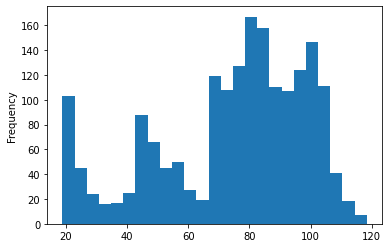

In [35]:
# Compare dsitribution between monthly charges and Totalcharges/months
df_disloyal['MonthlyCharges'].plot(kind='hist', bins=25);

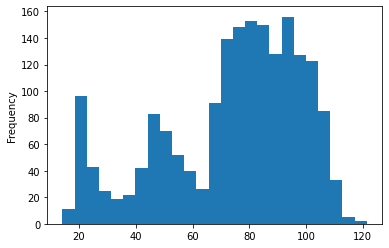

In [36]:
(df_disloyal['TotalCharges']/df_disloyal['spread']).plot(kind='hist', bins=25);

This shows similar graphs for regular installments, no matter if they are month to month or year to year payments. We then can say that we can fill the missing values given that the next total charge the next month will be _almost_ the same as the current monthly charge.

In [37]:
# Fill the missing values
df_cont['TotalCharges'] = np.where(df_cont['TotalCharges'] == " ", df_cont['MonthlyCharges'], df_cont['TotalCharges'] )

In [38]:
# Result
df_cont.query('BeginDate == "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,20.0
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,19.7
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,73.35


We no longer have missing values.

In [39]:
# Convert `TotalCharges` as float type
df_cont['TotalCharges'] = df_cont['TotalCharges'].astype(float)

Given that our model objective is to detect clients before leaving, we assign the people who already left a 1; 0 otherwise. 

In [40]:
# Create a label column with `EndDate`
df_cont['label'] = np.where(df_cont['EndDate'] == 'No', 0, 1)
df_cont.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,1,Electronic check,70.70,151.65,1


Now we have our principal dataframe completed, we can start diving in more deeply. We can change the type data for the date columns. Then we can calculate the difference between dates. Also, we can estimate the total charges with the number of months and the monthly charge and compare its value with the `totalCharges` variable.

In [41]:
# Change 'No' by last date one month before the last calculus of total charge -01 00:00:00'
df_cont['EndDate'] = np.where(df_cont['EndDate'] == 'No', '2020-02-01 00:00:00', df_cont['EndDate'])
# Change `EndDate` to datetime type
df_cont['EndDate'] = pd.to_datetime(df_cont['EndDate'], format='%Y-%m-%d')
# Calculate the spread between dates in motnths
df_cont['spread'] = (((df_cont['EndDate'] - df_cont['BeginDate'])) / np.timedelta64(1, 'M')).round()
# Calculate baseTotalCharges
df_cont['baseTotalCharges'] = df_cont['MonthlyCharges']*df_cont['spread']
# Calculate the differnece in the TotalCharge
df_cont['increment'] = df_cont['TotalCharges']-df_cont['baseTotalCharges']
# Efective payment per month
df_cont['baseMonthlyCharges'] = df_cont['TotalCharges']/df_cont['spread']

In [42]:
df_cont.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label,spread,baseTotalCharges,increment,baseMonthlyCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,1.0,29.85,0.00,29.850000
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,34.0,1936.30,-46.80,55.573529
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,107.70,0.45,54.075000


### Effective monthly payment rates

We are going to estimate rates among the people who has left and those who remain. By dividing the mean income per type of those who remain by the mean income of those who left, we can have an idea of how much the company earn per average client. Remember, in this case zero means "loyal". 

In [43]:
# Rate on Type payments
df_cont.query('label == 0 and spread > 0').groupby(['Type'])['baseMonthlyCharges'].mean()/df_cont.query('label == 1 and spread > 0').groupby(['Type'])['baseMonthlyCharges'].mean()

Type
Month-to-month    0.841357
One year          0.735713
Two year          0.693623
Name: baseMonthlyCharges, dtype: float64

In [44]:
# Rate by PaymenthMethod
df_cont.query('label == 0 and spread > 0').groupby(['PaymentMethod'])['baseMonthlyCharges'].mean()/df_cont.query('label == 1 and spread > 0').groupby(['PaymentMethod'])['baseMonthlyCharges'].mean()

PaymentMethod
Bank transfer (automatic)    0.836581
Credit card (automatic)      0.836567
Electronic check             0.942945
Mailed check                 0.758381
Name: baseMonthlyCharges, dtype: float64

**Observations:**

- In general, we charge less to the people who remain.
- In general, we charge less the longer the term.

### Months before leaving

 Additionaly, we show the distribution of the spread before leaving. 

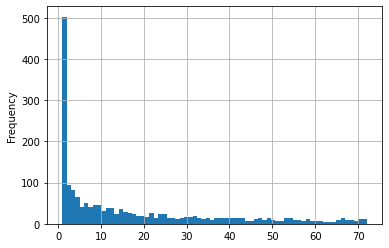

In [45]:
df_cont.query('label == 1 and spread > 0')['spread'].plot(kind='hist', bins=70, grid=True);

In [46]:
df_cont.query('label == 1 and spread > 0')['spread'].value_counts(normalize=True).head()

1.0    0.203317
2.0    0.065811
3.0    0.050294
4.0    0.044409
5.0    0.034243
Name: spread, dtype: float64

More than 20% percent of the people who left just lasted one month and the next 20 in the next 4 months, moreover, we know we have clients since the year 2013 but they have been leaving just in the last 4 months (from October 2019 to January 2020 ).

### Analysing the discrepancy in Total Charges

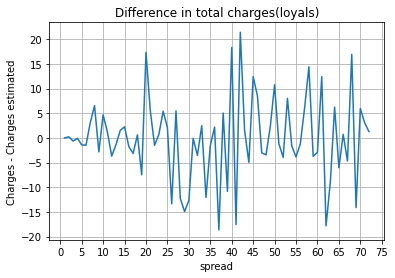

In [47]:
df_cont.query('label == 0 and spread > 0 ').groupby(['spread'])['increment'].mean().plot(
    kind='line', xticks=range(0,80,5), grid=True, ylabel='Charges - Charges estimated', title='Difference in total charges(loyals)');

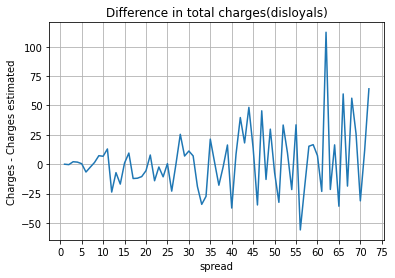

In [48]:
df_cont.query('label == 1 and spread > 0').groupby(['spread'])['increment'].mean().plot(
    kind='line', xticks=range(0,80,5), grid=True,  ylabel='Charges - Charges estimated', title='Difference in total charges(disloyals)');

In [49]:
# Mean difference by type of contract (loyals)
df_cont.query('label ==0 and spread > 0').groupby(['Type'])['increment'].mean()

Type
Month-to-month   -1.479144
One year          2.507542
Two year          0.449664
Name: increment, dtype: float64

In [50]:
# Mean difference by type of contract (disloyals)
df_cont.query('label ==1 and spread > 0').groupby(['Type'])['increment'].mean()

Type
Month-to-month   -0.030544
One year          5.063855
Two year         -9.167708
Name: increment, dtype: float64

**Observations:**

- The increments gravitate around zero.
- The domain with "loyals" is approximately (-18, 21); with "disloylas" is (-62.5, 125)
- The increments variance grow along with time. This is clearer for the "disloyals"  but more erratic for the 'loyals'.
- We are charging even more in the One year tipe in both cases.

## Questions.

- Why is there a difference between the monthly payments and the total charge divided by the number of months?
- Why are the clients leaving in this narrow window of time?
- How to add a variable of "Time in the company before leaving" for people who have not left. 

## Following steps.

- To apply OHE where necessary: We have converted some columns into binary numbers but there are some columns that still need the treatment.
- We will incorporate data from `df_inter`, `df_phone`, and `df_personal` into `df_cont`. In some cases we are going to preserve both columns to differenciate among clients with one or both services. However, `df_personal` already has every client, so this process will not be needed here.
- To divide datasets: It is always important to have a training and validation dataset.
- To try different models: By trying different models with different parameters we could select the best result. We will change the threshold in some models for its improvement.

# Modeling

## Preparations

First, we merge the dataframes and then apply an econding method for the remaining categorical columns. Second, we divide our dataset between two sets (training and validation set) and separate our label column. Subsequently, we will train different models and make adjustments on them if necessary.

### Merge dataframes and fill absent values.

In [51]:
# Merge all dataframes
df = df_cont.merge(df_personal, how='inner', on='customerID').merge(df_inter, how='left', on='customerID').merge(df_phone, how='left', on = 'customerID')

In [52]:
# Count nan values.
df.isna().sum()

customerID               0
BeginDate                0
EndDate                  0
Type                     0
PaperlessBilling         0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
label                    0
spread                   0
baseTotalCharges         0
increment                0
baseMonthlyCharges       0
gender                   0
SeniorCitizen            0
Partner                  0
Dependents               0
OnlineSecurity        1526
OnlineBackup          1526
DeviceProtection      1526
TechSupport           1526
StreamingTV           1526
StreamingMovies       1526
DSL                   1526
Fiber optic           1526
MultipleLines          682
SingleLine             682
dtype: int64

Now we have the expected missing values from merging the datasets. Observe how the values are the same that the ones we calculated earlier with set theory. It is necessary to fill them with zero because it adds relevant information.

In [53]:
# Filling the values wtih zero.
df = df.fillna(0)

### Eliminate innecessary columns and create train and test set.

In [54]:
# Eliminate columns we no longer need
eliminated = ['customerID', 'BeginDate', 'EndDate', 'baseTotalCharges', 'baseMonthlyCharges', 'SeniorCitizen', 'gender',]
df = df.drop(eliminated, axis=1)
# Divide our datasets
df_train, df_test = train_test_split(df, test_size=0.25, random_state=24601)
# Obtain the objective for train dataset
x_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']
# Obtain the objective for test dataset
x_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']

In [55]:
# Showing dimensions of our datatset
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5282, 19), (1761, 19), (5282,), (1761,))

In [56]:
# Showing the results for the dx_train dataset.
x_train.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine
583,Month-to-month,1,Mailed check,19.00,19.00,1.0,0.00,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2030,Month-to-month,0,Bank transfer (automatic),60.95,134.60,2.0,12.70,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
28,Two year,1,Credit card (automatic),90.25,6369.45,72.0,-128.55,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


### Apply OHE where necessary

In [57]:
# Create an OHE instance 
ohe = OneHotEncoder(sparse=False, drop='first')

# List of columns to change
ohe_columns = ['Type', 'PaymentMethod']

# New list of names to insert
new_columns = ['One Year', 'Two Year', 'Credit card', 'Electronic check', 'Mailed check']

#Create a dataframe to concat
condition_ohe_train = pd.DataFrame(ohe.fit_transform(x_train[ohe_columns]), columns=new_columns)
# Create our dataframe with ohe columns
xtrain = pd.concat([x_train.drop(columns= ohe_columns).reset_index(drop=False), condition_ohe_train], axis=1)
xtrain = xtrain.set_index('index')
# Show it
xtrain.head(3)


,PaperlessBilling,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine,One Year,Two Year,Credit card,Electronic check,Mailed check
index,,,,,,,,,,,,,,,,,,,,,
583,1,19.00,19.00,1.0,0.00,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2030,0,60.95,134.60,2.0,12.70,0,1,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28,1,90.25,6369.45,72.0,-128.55,1,0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [58]:

#Apply the same for the test set.
condition_ohe_test = pd.DataFrame(ohe.transform(x_test[ohe_columns]), columns=new_columns)
xtest = pd.concat([x_test.drop(columns= ohe_columns).reset_index(drop=False), condition_ohe_test], axis=1)
xtest = xtest.set_index('index') 
xtest.head(3)


,PaperlessBilling,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine,One Year,Two Year,Credit card,Electronic check,Mailed check
index,,,,,,,,,,,,,,,,,,,,,
2704,0,60.60,3297.00,53.0,85.20,1,1,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5165,1,69.65,69.65,1.0,0.00,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5257,1,101.10,3744.05,37.0,3.35,0,0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Apply Standard Scaler

In [59]:
#Create an instancia
ss = StandardScaler()
# list of numeric varibales
numericas = ['MonthlyCharges','TotalCharges','spread', 'increment']
# Transforming the values in the train set
xtrain[numericas] = ss.fit_transform(xtrain[numericas])
#Transforming the values in the test set
xtest[numericas] = ss.transform(xtest[numericas])

In [60]:
xtest.head(3)

,PaperlessBilling,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine,One Year,Two Year,Credit card,Electronic check,Mailed check
index,,,,,,,,,,,,,,,,,,,,,
2704,0,-0.134987,0.447955,0.837920,1.260778,1,1,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5165,1,0.167447,-0.974514,-1.278194,-0.005353,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5257,1,1.218445,0.644994,0.186808,0.044431,0,0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
xtrain.head(3)

,PaperlessBilling,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine,One Year,Two Year,Credit card,Electronic check,Mailed check
index,,,,,,,,,,,,,,,,,,,,,
583,1,-1.525178,-0.996839,-1.278194,-0.005353,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2030,0,-0.123290,-0.945887,-1.237499,0.183378,0,1,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28,1,0.855859,1.802151,1.611115,-1.915694,1,0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


### Imbalance treatment

In [62]:
def imb_treatment(x_train, y_train, times):
    #Separate df
    x_train_zeros = x_train[y_train==0]
    x_train_ones = x_train[y_train==1]
    y_train_zeros = y_train[y_train==0]
    y_train_ones = y_train[y_train==1]
    # Concatenate tables 
    x_train_up = pd.concat([x_train_zeros]+[x_train_ones]*times)
    y_train_up = pd.concat([y_train_zeros]+[y_train_ones]*times)
    # Shuffle data
    xtrain_up, y_train_up = shuffle(x_train_up, y_train_up, random_state=72)
    
    return xtrain_up, y_train_up

In [63]:
# With an upsample
xtrain_up, y_train_up = imb_treatment(xtrain, y_train, 3)

In [64]:
xtrain_up.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,spread,increment,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,DSL,Fiber optic,MultipleLines,SingleLine,One Year,Two Year,Credit card,Electronic check,Mailed check
index,,,,,,,,,,,,,,,,,,,,,
4322,1,0.184156,-0.950647,-1.237499,-0.250554,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6967,1,0.830795,-0.037250,-0.301526,-0.619842,0,0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3522,0,-1.498443,-0.706800,0.186808,-0.830864,1,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
581,0,0.356259,-0.972024,-1.278194,-0.005353,0,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5246,1,0.504969,-0.932709,-1.237499,0.068951,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [65]:
# Create a function to standardise column names
import re

def to_under(col):
    col = col.replace(' ', '_')
    p = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    return re.sub('([a-z0-9])(A-Z)', r'\1_\2', p).lower()

# Applying the function

xtrain.columns = [to_under(col) for col in xtrain.columns]
xtest.columns = [to_under(col) for col in xtest.columns]
xtrain_up.columns = [to_under(col) for col in xtrain_up.columns]

## Training and prediction with different models

We have prepared the data for every model. However, given that some models could perform well even with imbalanced data we can run every model with both datasets.

We have selected the following classification models:

- Dummy classifier as a sanity test.
- Logistic Regression
- Decision Tree
- Random Forest 
- KNeighbors 
- Gradient Boosting 
- LightGBM 
- CatBoost 

We can create a function for training our models and show results since we are using the same structure for each model.

In [66]:
def modeling(instance, params, x_train, y_train, x_test, y_test):
    #Eliminate warnings if present
    import warnings
    warnings.filterwarnings("ignore")
    # Grid for to implement
    model_grid = GridSearchCV(instance, params, cv=5, scoring='roc_auc')
    # Training
    start = time.time()
    model_grid.fit(x_train, y_train)
    end = time.time()
    # Results from training
    print('Best AUC-ROC score in training set:', model_grid.best_score_)
    print('')
    print('Best Params:', model_grid.best_params_)
    print('')
    model_omens = model_grid.predict_proba(x_test)[:,1]
    
    spread = (end-start)
    
    model_roc = roc_auc_score(y_test, model_omens)
    
    print('AUC-ROC score in test set:', model_roc, '\n' ,'Time for training: {:.3}s'.format(spread))
    
    return model_grid.best_score_, model_roc, spread

### Dummy classifier

In [67]:
dummy_a0, dummy_b0, dummy_c0 = modeling(DummyClassifier(),
        {'strategy':['prior','stratified', 'most_frequent']},
        xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.5039307389008088

Best Params: {'strategy': 'stratified'}

AUC-ROC score in test set: 0.47944502049079146 
 Time for training: 0.0817s


In [68]:
dummy_a, dummy_b, dummy_c = modeling(DummyClassifier(),
        {'strategy':['prior','stratified', 'most_frequent']},
        xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.501276046449453

Best Params: {'strategy': 'stratified'}

AUC-ROC score in test set: 0.48121759739297887 
 Time for training: 0.0698s


In [69]:
xtrain.shape, y_train.shape, xtest.shape, y_test.shape

((5282, 22), (5282,), (1761, 22), (1761,))

### LogisticRegression

In [70]:
log_params = {'penalty':['l2', 'l1'], 
          'solver': ['liblinear', 'saga', 'newton-cholesky'],
             'C': [1,6,8],
             'tol':[.0001,.0003],
             'class_weight':['balanced', None],
             'max_iter':[100,200]}

log_a0, log_b0, log_c0 = modeling(LogisticRegression(random_state=24601),
         log_params, 
         xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.8425347073716652

Best Params: {'C': 8, 'class_weight': None, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}

AUC-ROC score in test set: 0.8512055827120262 
 Time for training: 1.88e+02s


In [71]:
log_a, log_b, log_c = modeling(LogisticRegression(random_state=24601),
         log_params, 
         xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.843244281534718

Best Params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0003}

AUC-ROC score in test set: 0.8510097269540315 
 Time for training: 2.54e+02s


### DecisionTreeClassifier

In [72]:
tree_params = {'criterion': ['entropy', 'gini'],
               'class_weight': ['balanced', None],
               'splitter':['best', 'random'],
               'max_depth': [2,4,5,6,10,None,20]}

tree_a0, tree_b0, tree_c0 = modeling(DecisionTreeClassifier(random_state=24601), 
         tree_params, 
         xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.8263757231195857

Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}

AUC-ROC score in test set: 0.8441695880445695 
 Time for training: 6.43s


In [73]:
tree_a, tree_b, tree_c = modeling(DecisionTreeClassifier(random_state=24601), 
         tree_params, 
         xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.8908906611135523

Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}

AUC-ROC score in test set: 0.667150545598183 
 Time for training: 8.37s


### RandomForestClassifier

In [74]:
forest_params = {'n_estimators':[100, 110, 90],
                 'criterion':['gini', 'entropy'],
                 'class_weight':['balanced', None]}

forest_a0, forest_b0, forest_c0 = modeling(RandomForestClassifier(random_state=24601), 
         forest_params, 
         xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.8230834476637277

Best Params: {'class_weight': None, 'criterion': 'entropy', 'n_estimators': 110}

AUC-ROC score in test set: 0.8390139732385328 
 Time for training: 43.5s


In [75]:
forest_a, forest_b, forest_c = modeling(RandomForestClassifier(random_state=24601), 
         forest_params, 
         xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.9736739728032664

Best Params: {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 100}

AUC-ROC score in test set: 0.8324165967181817 
 Time for training: 60.3s


### GradientBoostingClassifier

In [78]:
boost_params = {'learning_rate':[float(i) for i in list(np.linspace(.1,.9,4))], 
                'subsample':[0.9,1,3], 
                'loss':['exponential', 'log_loss'],
                'n_estimators' : [int(x) for x in np.linspace(50,300,6)] }

boost_a0, boost_b0, boost_c0 = modeling(GradientBoostingClassifier(random_state=24601),
        boost_params,
        xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.844584604553754

Best Params: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50, 'subsample': 1}

AUC-ROC score in test set: 0.8554946592274395 
 Time for training: 3.79e+02s


In [79]:
boost_a, boost_b, boost_c = modeling(GradientBoostingClassifier(random_state=24601),
        boost_params,
        xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.9200168729615251

Best Params: {'learning_rate': 0.9, 'loss': 'exponential', 'n_estimators': 300, 'subsample': 1}

AUC-ROC score in test set: 0.8066780230089369 
 Time for training: 5.4e+02s


### KNeighborsClassifier

In [80]:
kneigh_params = {'n_neighbors':[2,5,10, 30, 70,100,300],
                'weights':['uniform','distance'],
                'leaf_size':[2,4,8],
                'algorithm':['ball_tree','kd_tree','brute'],
                'p':[1,2]}

neig_a0, neig_b0, neig_c0 = modeling(KNeighborsClassifier(), 
        kneigh_params,
        xtrain, y_train, xtest, y_test)

Best AUC-ROC score in training set: 0.8354194397274235

Best Params: {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 70, 'p': 1, 'weights': 'uniform'}

AUC-ROC score in test set: 0.8466021494757978 
 Time for training: 4.36e+02s


In [81]:
neig_a, neig_b, neig_c = modeling(KNeighborsClassifier(), 
        kneigh_params,
        xtrain_up, y_train_up, xtest, y_test)

Best AUC-ROC score in training set: 0.9891917702843813

Best Params: {'algorithm': 'brute', 'leaf_size': 2, 'n_neighbors': 300, 'p': 2, 'weights': 'distance'}

AUC-ROC score in test set: 0.8330955084843397 
 Time for training: 7.22e+02s


### LightGBM

In [ ]:
lgbm_params = {'learning_rate':[float(i) for i in list(np.linspace(.03,.125,4))],
               'class_weight':['balanced','is_unbalanced', 'scale_pos_weight'],
               'n_estimators':[100,200],
               'num_leaves':[int(x) for x in np.linspace(31,39,4)]}

gbm_a0, gbm_b0, gbm_c0 = modeling(LGBMClassifier(verbose=0, objective='binary', force_row_wise=True),
        lgbm_params,
        xtrain, y_train, xtest, y_test)

In [ ]:
gbm_a, gbm_b, gbm_c = modeling(LGBMClassifier(verbose=2),
        lgbm_params,
        xtrain_up, y_train_up, xtest, y_test)

### CATBoostClassifier

In [103]:
catb_params = {'depth':[4,5,12],
              'iterations':[20,50,100,],
              'learning_rate':[.15, .2, .25],
               'scale_pos_weight': [.3,3]
              }

catb_a0, catb_b0, catb_c0 = modeling(CatBoostClassifier(verbose=False, loss_function='Logloss'),
        catb_params, 
        xtrain, y_train, xtest, y_test)


Best AUC-ROC score in training set: 0.8442771345786039

Best Params: {'depth': 4, 'iterations': 50, 'learning_rate': 0.15, 'scale_pos_weight': 3}

AUC-ROC score in test set: 0.8582736713902467 
 Time for training: 6.84e+02s


In [102]:
catb_a, catb_b, catb_c = modeling(CatBoostClassifier(verbose=False, loss_function='Logloss'),
        catb_params, 
        xtrain_up, y_train_up, xtest, y_test)


Best AUC-ROC score in training set: 0.957543775281329

Best Params: {'learning_rate': 0.25, 'scale_pos_weight': 3}

AUC-ROC score in test set: 0.8156100330815188 
 Time for training: 1.4e+02s


## Summary


### Results with dataset without imbalance adjustment

In [93]:
values0 = np.array([ 
    [dummy_a0, dummy_b0, dummy_c0], 
    [log_a0, log_b0, log_c0],
    [tree_a0, tree_b0, tree_c0],
    [forest_a0, forest_b0, forest_c0],
    [neig_a0, neig_b0, neig_c0],
    [boost_a0, boost_b0, boost_c0],
    [gbm_a0, gbm_b0, gbm_c0],
    [catb_a0, catb_b0, catb_c0]
]
)

index0 = ['Dummy', 'Logit', 'DTree', 'RForest', 'Kneighbor', 'GradientBoost', 'LGBM', 'Catboost']

column_names0=['AUC-ROC validation set', 'AUC-ROC test set', 'Time predicting (s)']

summary0 = pd.DataFrame(values0, index0, column_names0)

In [94]:
summary0

,AUC-ROC validation set,AUC-ROC test set,Time predicting
Dummy,0.503931,0.479445,0.081743
Logit,0.842535,0.851206,0.851206
DTree,0.826376,0.844170,6.431003
RForest,0.823083,0.839014,43.542270
Kneighbor,0.835419,0.846602,436.320176
GradientBoost,0.844585,0.855495,379.058202
LGBM,0.834781,0.849303,2561.171145
Catboost,0.813894,0.826284,795.978539


### Results with dataset with imbalance adjustment

In [95]:
values = np.array([ 
    [dummy_a0, dummy_b0, dummy_c0], 
    [log_a, log_b, log_c],
    [tree_a, tree_b, tree_c],
    [forest_a, forest_b, forest_c],
    [neig_a, neig_b, neig_c],
    [boost_a, boost_b, boost_c],
    [gbm_a, gbm_b, gbm_c],
    [catb_a, catb_b, catb_c]
]
)

index = ['Dummy', 'Logit', 'DTree', 'RForest', 'Kneighbor', 'GradientBoost', 'LGBM', 'Catboost']

column_names=['AUC-ROC validation set', 'AUC-ROC test set', 'Time predicting (s)']

summary = pd.DataFrame(values, index, column_names)

In [96]:
summary

,AUC-ROC validation set,AUC-ROC test set,Time predicting
Dummy,0.503931,0.479445,0.081743
Logit,0.843244,0.851010,0.851010
DTree,0.890891,0.667151,8.366128
RForest,0.973674,0.832417,60.297551
Kneighbor,0.989192,0.833096,722.302928
GradientBoost,0.920017,0.806678,539.832982
LGBM,0.972045,0.812917,3418.696120
Catboost,0.968318,0.832859,817.816219


## Conclusion

We started by downloading the info and importing the necessesary libraries. We visualise the dimensions, characteristics, and distribution for each dataframe. Since our objective was to detect people who left and who stayed our models were all classifiers and our label binary.  

The datasets were mostly correct and complete and few adjustments were necessary. We found neither typos, duplicated values, nor outstanding outliers. However, it was necessary to prove we had complete data and that missing values in `df_phone` and `df_inter` were due to the structure of the dataframes and not missing at random values. We then change yes-no variables into integer answers so they could be interpreted by the models. We just had eleven rows with missing values but they were even filled successfully through analysis. 

We created more variables and analysed the contract-dataframe for a deeper understanding of the data. We found we charged, in general, less to the people who stay, that our clients were leaving in this very recent 4 months and that the differences between the total charges registered and the total charges we calculated were broader for the people who left.

We then merge all dataframes and fill the missing values with zeros since that implied that some clients simply did not have those services (which was important information by itself). We divided the complete dataframe into training and testing sets and separated our label column. Since we still had some categorical variables with few categories we used One Hot Encoder. Then, we had a complete dataframe with zeros and ones. The remaining numeric columns were scaled using Standard Scaler for correct training. We had imbalanced data so we applied a simple way to upsample it. Finally, since some models perform better with snake case columns, we applied regular expressions to transform column names where needed.  

For the modeling section we created a function that allow us to select different paramteres among models (including imbalance treatment parameters) while avoiding code repetition. The models implemented here were: Dummy, Logit, Decision Tree, Random Forest, Kneighbor, Gradient Boost, LightGBM, and CatBoost. The Dummy model was implemented as a sanity test. With these 8 classifiers we model for the upsampled and for the not-upsmapled dataset. Therefore, we ran 16 models. The metric used was AUC-ROC. The models with the not-upsampled data proved to perform better. They reached higher results, between 0.839 and 0.855, compared to the upsample dataset, 0.801 - 0.851 (excluding the even worse Decision Tree model performance). Moreover, the signs of overfitting were clear in the upsampled dataset.

The best model, considering the AUC-ROC metric reached and the time for training, was the Logistic Regression model with an AUC-ROC score of 0.851.

## Further discussions

We still can change our threshold in order to minimise the costs of a false positive and a false negative error. More information is required to determine the direction and magnitude of the change. In other words, is it more expensive giving a discount to a person who would have not left or not giving it to a person who is planning to leave? How can we determine a person stayed just because of the discount and exclude other reasons (after all, she might not have left)? Since all the people who have abandoned left in a really narrow window of time, it suggests that it is more important to give discounts to deter them from leaving. However, this is a short run solution and the underlying answer could be different and therefore more reseach is strongly advisable. Lastly, given that the AUC-ROC metric represents the magnitude of the area but ignores its form, this means we need to plot the curves of each model to select the best. 